# Cough Annotation
In this notebook, we demonstrate an example of how the manual annotation was performed to delineate each cough sound, integrating information from the outward-facing microphone and accelerometer z signals. The fiducial points from these signals are extracted and then manually selected to annotate the start and stop of each cough sound.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import IPython.display as ipd
from enum import Enum
sys.path.append(os.path.abspath('../src'))
from helpers import *

### Load and plot data
Plot a recording of the subject sitting in a non-noisy environment while a bystander is coughing.

In [2]:
data_folder = '../../data/public_dataset/' #Path to the public dataset location
subj_ids = os.listdir(data_folder)
subject = subj_ids[9]
sound = Sound.COUGH
trial = Trial.ONE
noise = Noise.COUGH
mov = Movement.SIT

In [4]:
audio, _ = load_audio(data_folder, subject, trial, mov, noise, sound)
imu = load_imu(data_folder, subject, trial, mov, noise, sound)
imu.normalize()

In [5]:
# Segment the signal and normalize for visualization purposes
start = 0
end = 3
audio = audio[int(start*FS_AUDIO):int(end*FS_AUDIO)]
audio = audio - np.mean(audio)
audio = audio/np.max(audio)
imu_z = -imu.z[int(start*FS_IMU):int(end*FS_IMU)]
imu_time = imu.get_time()[int(start*FS_IMU):int(end*FS_IMU)]
imu_time = imu_time - imu_time[0]

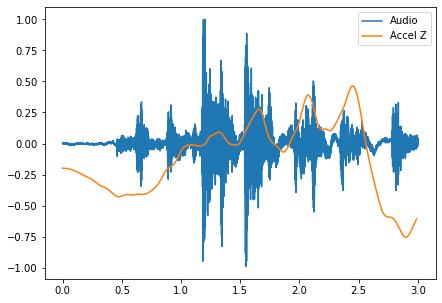

In [6]:
fig = plt.figure(figsize=(7,5))
plt.plot(get_audio_time(audio),audio,label = "Audio")
plt.plot(imu_time,imu_z, label = 'Accel Z')
plt.legend()

In [7]:
# Play the sound to hear both coughs at once
ipd.Audio(audio, rate=FS_AUDIO, autoplay=True)

### Extract fiducial points
Extract the audio burst starts and stops, as well as IMU peaks and valleys

In [8]:
# Segment cough audio and extract peaks
pad=0.02
th_l = 0.1
th_h =0.5
min_len = 0.02
_, _, audio_starts, audio_ends, audio_peaks, audio_peak_locs = segment_cough(audio,FS_AUDIO, cough_padding=pad,min_cough_len=min_len, th_l_multiplier = th_l, th_h_multiplier = th_h)


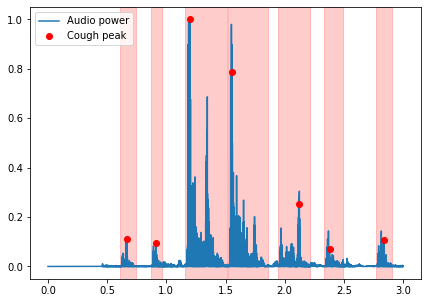

In [9]:
# Plot audio segments on squared signal to adjust thresholds
fs = FS_AUDIO
air = audio
fig = plt.figure(figsize=(7,5))
air_time = get_audio_time(air)
plt.plot(air_time ,air**2,label = "Audio power")
for s, e in zip(audio_starts,audio_ends):
    plt.axvspan(s/fs,e/fs,-1,1, alpha=0.2, color='red')
plt.scatter(np.array(audio_peak_locs)/fs, np.array(audio_peaks)**2, color='red', label='Cough peak', zorder=10)
plt.legend()

We can see that both the user's coughs and bystander's coughs are segmented by this method

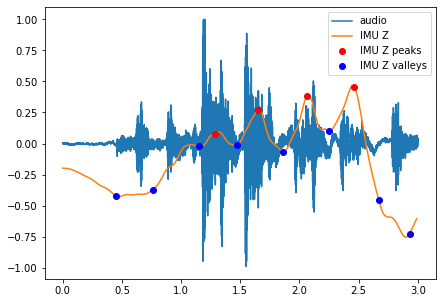

In [10]:
# Detect IMU peaks from second derivative
imu_pks, imu_valleys, second_deriv_imu = delineate_imu(imu_z)
threshold = 0
imu_pks = imu_pks[(imu_z[imu_pks])>threshold]
plt.figure(figsize=(7,5))
plt.plot(air_time ,air,label = "audio")
plt.plot(imu_time,imu_z, label = 'IMU Z')
# plt.plot(imu.get_time(),second_deriv_imu)
plt.scatter(imu_pks/imu.fs,imu_z[imu_pks],label='IMU Z peaks', color='red', zorder=11)
# plt.scatter(valleys/imu.fs,second_deriv_imu[valleys],label='IMU Z valleys', color='blue')
plt.scatter(imu_valleys/imu.fs,imu_z[imu_valleys],label='IMU Z valleys', color='blue', zorder=10)
plt.legend()

The four cough peaks are properly delineated, but there are some false positives as well. Note that some thresholding is done to delete peaks and valleys that are too low. This was part of the manual annotation process.

### Annotation
This is just an example of which fiducial points can be selected, but in this case we see that the true coughs lie where an IMU peak exists within the start and stop of an audio burst. We set that up as the criteria and measure the cough from the audio onset to the IMU valley.

In [11]:
final_annotation = []
imu_pks_time = imu_pks/imu.fs
imu_vls_time = imu_valleys/imu.fs
for s,e in zip(audio_starts/FS_AUDIO, audio_ends/FS_AUDIO):
    if np.any((imu_pks_time >= s) & (imu_pks_time <= e)):
        final_annotation.append((s,find_nth_closest_point(s, imu_vls_time, pos='after')))

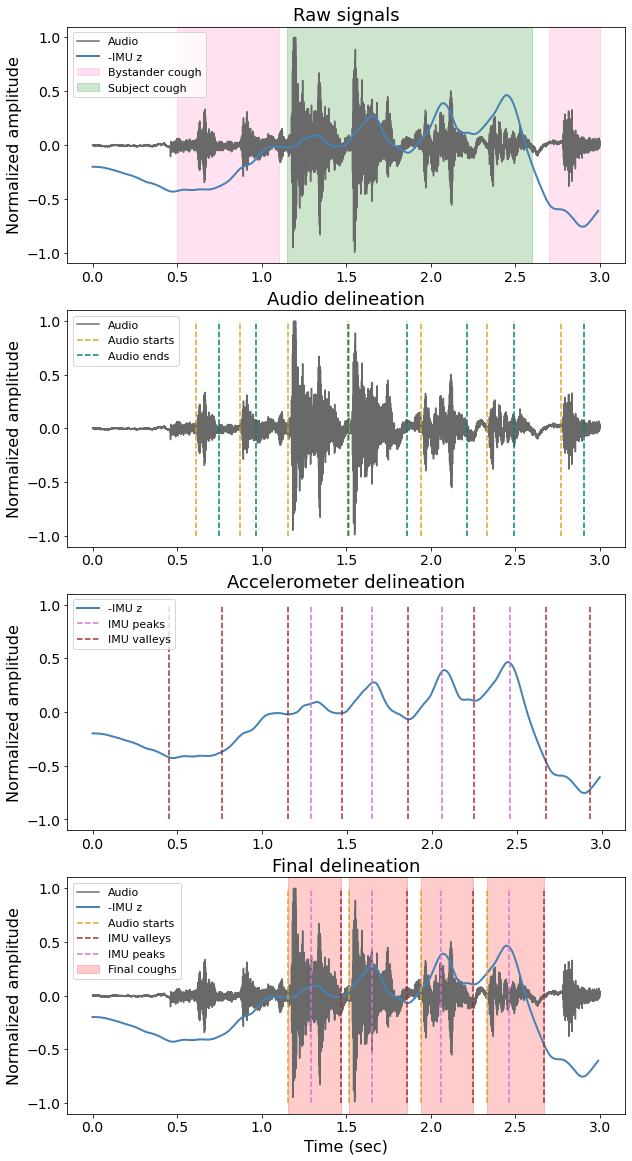

In [16]:
fig, axs = plt.subplots(4,1, figsize=(10,20))
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
axs[0].plot(air_time ,air,label = "Audio", color='dimgrey')
axs[0].plot(imu_time,imu_z, label = '-IMU z', color='steelblue', linewidth=2)
axs[0].set_title("Raw signals", fontsize=18)
axs[0].axvspan(0.5,1.1,-1,1, alpha=0.2, color='hotpink', label = 'Bystander cough')
axs[0].axvspan(2.7,air_time[-1],-1,1, alpha=0.2, color='hotpink')
axs[0].axvspan(1.15,2.6,-1,1, alpha=0.2, color='green', label='Subject cough')
axs[0].legend(loc="upper left", fontsize=11)
axs[0].set_ylabel("Normalized amplitude", fontsize=16)
axs[1].plot(air_time ,air,label = "Audio", color='dimgrey')
axs[1].vlines(audio_starts/FS_AUDIO, -1, 1, color='goldenrod',linestyle='dashed', label = "Audio starts")
axs[1].vlines(audio_ends/FS_AUDIO, -1, 1, color='teal',linestyle='dashed', label = "Audio ends")
axs[1].legend(loc="upper left", fontsize=11)
axs[1].set_title("Audio delineation", fontsize=18)
axs[1].set_ylabel("Normalized amplitude", fontsize=16)
axs[2].plot(imu_time,imu_z, label = '-IMU z', color='steelblue', linewidth=2)
axs[2].vlines(imu_pks/imu.fs, -1, 1, color='orchid',linestyle='dashed', label = "IMU peaks")
axs[2].vlines(imu_valleys/imu.fs, -1, 1, color='brown',linestyle='dashed', label = "IMU valleys")
axs[2].legend(loc="upper left", fontsize=11)
axs[2].set_title("Accelerometer delineation", fontsize=18)
axs[2].set_ylabel("Normalized amplitude", fontsize=16)
axs[3].plot(air_time ,air,label = "Audio", color='dimgrey')
axs[3].plot(imu_time,imu_z, label = '-IMU z', color='steelblue', linewidth=2)
for i, (s,e) in enumerate(final_annotation):
    if i==0:
        axs[3].vlines([s],-1, 1, color='goldenrod',linestyle='dashed', label = "Audio starts")
        axs[3].vlines([e],-1, 1, color='brown',linestyle='dashed', label = "IMU valleys")
        axs[3].vlines(find_nth_closest_point(s,imu_pks_time,"after"), -1, 1, color='orchid',linestyle='dashed', label = "IMU peaks")
        axs[3].axvspan(s,e,-1,1, alpha=0.2, color='red', label="Final coughs")
    else:
        axs[3].axvspan(s,e,-1,1, alpha=0.2, color='red')
        axs[3].vlines([s],-1, 1, color='goldenrod',linestyle='dashed')
        axs[3].vlines([e],-1, 1, color='brown',linestyle='dashed')
        axs[3].vlines(find_nth_closest_point(s,imu_pks_time,"after"), -1, 1, color='orchid',linestyle='dashed')

axs[3].legend(loc="upper left", fontsize=11)
axs[3].set_title("Final delineation", fontsize=18)
axs[3].set_xlabel("Time (sec)", fontsize=16)
axs[3].set_ylabel("Normalized amplitude", fontsize=16)